
# Torchscript support

<div class="alert alert-info"><h4>Note</h4><p>Try on [Colab](https://colab.research.google.com/github/pytorch/vision/blob/gh-pages/main/_generated_ipynb_notebooks/plot_scripted_tensor_transforms.ipynb)
    or `go to the end <sphx_glr_download_auto_examples_others_plot_scripted_tensor_transforms.py>` to download the full example code.</p></div>

This example illustrates [torchscript](https://pytorch.org/docs/stable/jit.html) support of the torchvision
`transforms <transforms>` on Tensor images.


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision.transforms as v1
from torchvision.io import decode_image

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

# If you're trying to run that on Colab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
import sys
sys.path += ["../transforms"]
#from helpers import plot
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, bbox_width=3, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target

                    # Conversion necessary because draw_bounding_boxes() only
                    # work with this specific format.
                    if tv_tensors.is_rotated_bounding_format(boxes.format):
                        boxes = v2.ConvertBoundingBoxFormat("xyxyxyxy")(boxes)
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=bbox_width)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

ASSETS_PATH = Path('../assets')

Most transforms support torchscript. For composing transforms, we use
:class:`torch.nn.Sequential` instead of
:class:`~torchvision.transforms.v2.Compose`:



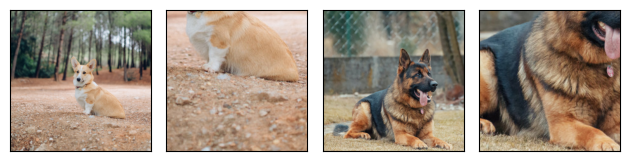

In [5]:
#dog1 = decode_image(str(ASSETS_PATH / 'dog1.jpg'))
#dog2 = decode_image(str(ASSETS_PATH / 'dog2.jpg'))

dog1 = decode_image('../content/dog1.jpeg')
dog2 = decode_image('../content/dog2.jpeg')

transforms = torch.nn.Sequential(
    v1.RandomCrop(224),
    v1.RandomHorizontalFlip(p=0.3),
)

scripted_transforms = torch.jit.script(transforms)

plot([dog1, scripted_transforms(dog1), dog2, scripted_transforms(dog2)])

<div class="alert alert-danger"><h4>Warning</h4><p>Above we have used transforms from the ``torchvision.transforms``
    namespace, i.e. the "v1" transforms. The v2 transforms from the
    ``torchvision.transforms.v2`` namespace are the `recommended
    <v1_or_v2>` way to use transforms in your code.

    The v2 transforms also support torchscript, but if you call
    ``torch.jit.script()`` on a v2 **class** transform, you'll actually end up
    with its (scripted) v1 equivalent.  This may lead to slightly different
    results between the scripted and eager executions due to implementation
    differences between v1 and v2.

    If you really need torchscript support for the v2 transforms, **we
    recommend scripting the functionals** from the
    ``torchvision.transforms.v2.functional`` namespace to avoid surprises.</p></div>

Below we now show how to combine image transformations and a model forward
pass, while using ``torch.jit.script`` to obtain a single scripted module.

Let's define a ``Predictor`` module that transforms the input tensor and then
applies an ImageNet model on it.



In [6]:
from torchvision.models import resnet18, ResNet18_Weights


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.resnet18 = resnet18(weights=weights, progress=False).eval()
        self.transforms = weights.transforms(antialias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.resnet18(x)
            return y_pred.argmax(dim=1)

Now, let's define scripted and non-scripted instances of ``Predictor`` and
apply it on multiple tensor images of the same size



In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

predictor = Predictor().to(device)
scripted_predictor = torch.jit.script(predictor).to(device)

batch = torch.stack([dog1, dog2]).to(device)

res = predictor(batch)
res_scripted = scripted_predictor(batch)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


We can verify that the prediction of the scripted and non-scripted models are
the same:



In [11]:
import json

#with open(Path('../assets') / 'imagenet_class_index.json') as labels_file:
with open(Path('../content') / 'imagenet_class_index.json') as labels_file:
    labels = json.load(labels_file)

for i, (pred, pred_scripted) in enumerate(zip(res, res_scripted)):
    assert pred == pred_scripted
    print(f"Prediction for Dog {i + 1}: {labels[str(pred.item())]}")

Prediction for Dog 1: ['n02113023', 'Pembroke']
Prediction for Dog 2: ['n02106662', 'German_shepherd']


Since the model is scripted, it can be easily dumped on disk and re-used



In [12]:
import tempfile

with tempfile.NamedTemporaryFile() as f:
    scripted_predictor.save(f.name)

    dumped_scripted_predictor = torch.jit.load(f.name)
    res_scripted_dumped = dumped_scripted_predictor(batch)
assert (res_scripted_dumped == res_scripted).all()